In [1]:
import os
import time
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt
from torch.distributions.uniform import Uniform
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torchinfo import summary
from rich.progress import Progress
from rich.console import Console
from rich.table import Table

In [2]:
class LegoBricksDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.total_images = len(os.listdir(path=self.img_dir))
        self.img_paths = [os.path.join(self.img_dir, i) for i in os.listdir(path=self.img_dir)]

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        img = read_image(path=self.img_paths[idx], mode=ImageReadMode.GRAY)
        
        if self.transform:
            img = self.transform(img)

        return img

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(kernel_size=4, in_channels=1, out_channels=64, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),
            
            nn.Conv2d(kernel_size=4, in_channels=64, out_channels=128, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3), 
            
            nn.Conv2d(kernel_size=4, in_channels=128, out_channels=256, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),

            nn.Conv2d(kernel_size=4, in_channels=256, out_channels=512, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(num_features=512, momentum=0.9),
            nn.LeakyReLU(0.2), 
            nn.Dropout(0.3),

            nn.Conv2d(kernel_size=4, in_channels=512, out_channels=1, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(torch.Size([100, 1, 1]))),
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(num_features=512, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
discriminator = Discriminator()
discriminator.to(device)

summary(discriminator, input_size=[(1, 1, 64, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,024
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Dropout: 2-3                      [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-5                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-6                    [1, 128, 16, 16]          --
│    └─Dropout: 2-7                      [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-9                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-10                   [1, 256, 8, 8]            --
│    └─Dropout: 2-11                     [1, 256, 8, 8]            --


In [7]:
generator = Generator()
generator.to(device)

summary(generator, input_size=[(1, 100)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 1, 64, 64]            --
│    └─Unflatten: 2-1                    [1, 100, 1, 1]            --
│    └─ConvTranspose2d: 2-2              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-3                  [1, 512, 4, 4]            1,024
│    └─LeakyReLU: 2-4                    [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-5              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-6                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-7                    [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-8              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-10                   [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-11             [1, 64, 32, 32]       

In [8]:
learning_rate_generator = 0.0002
learning_rate_discriminator = 0.0002
beta_1 = 0.5
beta_2 = 0.999
batch_size = 128
epochs = 300

In [9]:
discriminator_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate_generator, betas=(beta_1, beta_2))
generator_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate_discriminator, betas=(beta_1, beta_2))

In [10]:
discriminator_loss = nn.BCELoss()
generator_loss = nn.BCELoss()

In [11]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
        v2.Resize((64, 64)),
    ]
)

train_dataset = LegoBricksDataset('dataset/lego-bricks/', transform=transform)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
def train_loop(dataloader, 
               discriminator, 
               generator, 
               discriminator_optimizer, 
               generator_optimizer, 
               discriminator_loss,
               generator_loss,
               current_epoch,
               total_epochs,
               device):
    start_time = time.time()
    
    total_batches = len(dataloader)
    discriminator_total_loss = 0
    generator_total_loss = 0

    with Progress() as progress:
        total_batches = progress.add_task(f'[red]Epoch {current_epoch}/{epochs}', total=total_batches)

        while not progress.finished:
            for current_batch, (current_batch_data) in enumerate(dataloader):
                current_batch_size = current_batch_data.shape[0]
                batch_size = current_batch_size
                
                # ======================
                # Discriminator Training
                # ======================
                discriminator.train()
                discriminator_optimizer.zero_grad()
                
                current_batch_data = current_batch_data.to(device)
                random_latent_vectors = torch.randn(size=(batch_size, 100)).to(device)
        
                real_imgs = current_batch_data
                fake_imgs = generator(random_latent_vectors)
        
                real_preds = discriminator(real_imgs)
                fake_preds = discriminator(fake_imgs.detach())
        
                real_grnds = torch.ones_like(real_preds) - 0.1 * torch.rand(real_preds.shape).to(device)
                fake_grnds = torch.zeros_like(fake_preds) + 0.1 * torch.rand(fake_preds.shape).to(device)
        
                real_disc_loss = discriminator_loss(real_preds, real_grnds)
                fake_disc_loss = discriminator_loss(fake_preds, fake_grnds)
                total_disc_loss = real_disc_loss + fake_disc_loss
        
                real_disc_loss.backward()
                fake_disc_loss.backward()
                discriminator_optimizer.step()
                
                discriminator_total_loss += total_disc_loss.item()
        
                # ==================
                # Generator Training
                # ==================
                generator.train()
                generator_optimizer.zero_grad()
        
                fake_preds_gen = discriminator(fake_imgs)
                real_grnds_gen = torch.ones_like(fake_preds_gen)
        
                gen_loss = generator_loss(fake_preds_gen, real_grnds_gen)
        
                gen_loss.backward()
                generator_optimizer.step()
        
                generator_total_loss += gen_loss.item()

                progress.update(total_batches, advance=1)
    
    avg_disc_loss = discriminator_total_loss / len(dataloader)
    avg_genr_loss = generator_total_loss / len(dataloader)

    end_time = time.time()

    table = Table(title=f'Epoch {current_epoch} Summary')
    
    table.add_column("Discriminator Loss", justify="left", style="cyan", no_wrap=True)
    table.add_column("Generator Loss", justify="left", style="cyan", no_wrap=True)
    table.add_column("Time Taken (seconds)", justify="left", style="cyan", no_wrap=True)

    table.add_row(f'{avg_disc_loss}', f'{avg_genr_loss}', f'{end_time - start_time}')
    
    console = Console()
    console.print(table)

In [13]:
def plot_and_save_generated_images_from_noise(n, generator, current_epoch):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(size=(n, 100)).to(device)
        generated = generator(z).detach().cpu()
        grid = make_grid(generated, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')
        plt.axis("off")
        plt.savefig(f'epoch-{current_epoch}.png', bbox_inches='tight')
        plt.show()

Output()

                         Epoch 1 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3457727786451102 │ 2.6194715530346757 │ 72.2015323638916     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 2 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.33917311014839635 │ 2.571867927956505 │ 72.18646144866943    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 3 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5601217141166662 │ 1.9749320506002195 │ 72.06515622138977    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 4 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5773825601647837 │ 1.4711400337112597 │ 72.04008436203003    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 5 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5428093227144247 │ 1.7279057887415536 │ 72.07098054885864    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 6 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.533411273464989  │ 1.6598552752988407 │ 71.79512476921082    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 7 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.536436303735922  │ 1.6529020793712177 │ 71.39867568016052    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 8 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5234224482085377 │ 1.714237039462446 │ 71.3891978263855     │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 9 Summary                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5208910922653759 │ 1.6451513870074725 │ 71.43182682991028    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 10 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.5156807903283701 │ 1.6477362531633042 │ 71.30391144752502    │
└────────────────────┴────────────────────┴──────────────────────┘

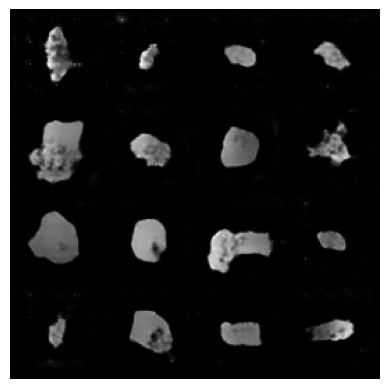

Output()

                         Epoch 11 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.49772591836536273 │ 1.7353218224482796 │ 71.38162350654602    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 12 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.48271679259336797 │ 1.8034614316952495 │ 71.30139756202698    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 13 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4748209428292113 │ 1.8304448891371583 │ 71.30512714385986    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 14 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.46038142503640905 │ 1.8382626004493274 │ 71.44849276542664    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 15 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4611660847648645 │ 1.8469845483097405 │ 71.30036044120789    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 16 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.44720637960174975 │ 1.8721047982621117 │ 71.32397413253784    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 17 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.45053477313952706 │ 1.9427490139159913 │ 72.95301556587219    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 18 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.45158933022151737 │ 1.9052344314968244 │ 72.23649621009827    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 19 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.44207692032043167 │ 1.946966571358446 │ 72.24800086021423    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 20 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.43549524890348174 │ 1.9853264674211082 │ 73.80836343765259    │
└─────────────────────┴────────────────────┴──────────────────────┘

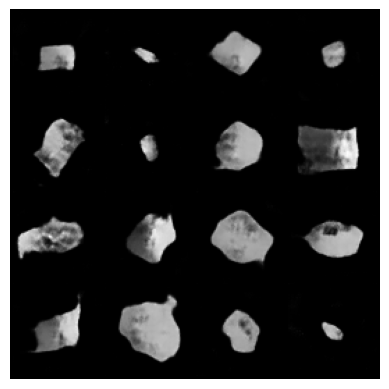

Output()

                         Epoch 21 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4264166748371368 │ 2.0513005963148783 │ 72.67970156669617    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 22 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.44368357761218524 │ 1.9483668539470758 │ 71.97458362579346    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 23 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.42940460712003253 │ 2.0162801475951464 │ 72.00139331817627    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 24 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.44352820772713364 │ 1.9494295188794122 │ 72.09344816207886    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 25 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4165814441804307 │ 2.060298072644316 │ 71.84320878982544    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 26 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.44385813609860575 │ 1.9570034705221462 │ 71.40087676048279    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 27 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4177490976481392 │ 2.0641001485788024 │ 71.33320021629333    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 28 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.42476245608573526 │ 2.0316414206553572 │ 71.34050393104553    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 29 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4158371920212389 │ 2.0387254414467004 │ 71.30842685699463    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 30 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.42872828073775804 │ 2.0560068916588925 │ 71.35372281074524    │
└─────────────────────┴────────────────────┴──────────────────────┘

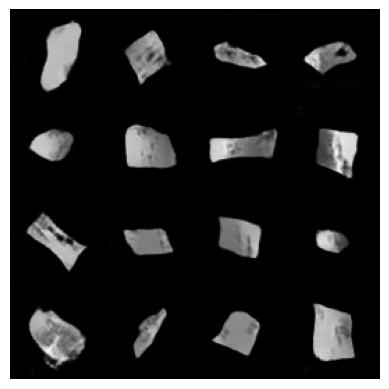

Output()

                        Epoch 31 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4286296224822632 │ 2.018822663317854 │ 71.43576502799988    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 32 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.41567739834800693 │ 2.07635190083196 │ 71.30288863182068    │
└─────────────────────┴──────────────────┴──────────────────────┘

Output()

                         Epoch 33 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4115864090835705 │ 2.1398386654381554 │ 71.3652286529541     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 34 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4477545476188294 │ 2.0008099082940682 │ 71.31696963310242    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 35 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.42227407956656554 │ 2.007117331218415 │ 71.39865946769714    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 36 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.406228005981293  │ 2.1283992707919768 │ 71.3571388721466     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 37 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4224410816884269 │ 2.093801272182038 │ 71.32783126831055    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 38 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4213259356280866 │ 2.0956780289689574 │ 71.37160181999207    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 39 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4077617820269003 │ 2.113857308896586 │ 71.30586242675781    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 40 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.42232987218009777 │ 2.0946167509395854 │ 71.35242938995361    │
└─────────────────────┴────────────────────┴──────────────────────┘

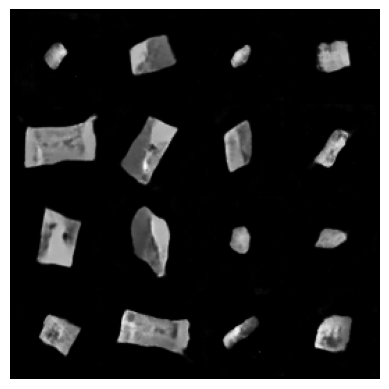

Output()

                         Epoch 41 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40903312415360643 │ 2.1411807112419567 │ 71.35150241851807    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 42 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4078484069044217 │ 2.1213300607074945 │ 71.31838607788086    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 43 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4134977681758686 │ 2.127017035461462 │ 71.36506175994873    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 44 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4017194033430788 │ 2.1687090038872374 │ 71.29095029830933    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 45 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4394877069293501 │ 2.0150824477211735 │ 71.35207605361938    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 46 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4170503304979672 │ 2.115105628776855 │ 71.36526846885681    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 47 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40719579622006646 │ 2.133604742277164 │ 71.35492014884949    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 48 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40365313207760406 │ 2.1654337707418985 │ 71.43127727508545    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 49 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4032184651103644 │ 2.1618877818790105 │ 71.37887763977051    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 50 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3962513403580212 │ 2.204095799511614 │ 71.38170671463013    │
└────────────────────┴───────────────────┴──────────────────────┘

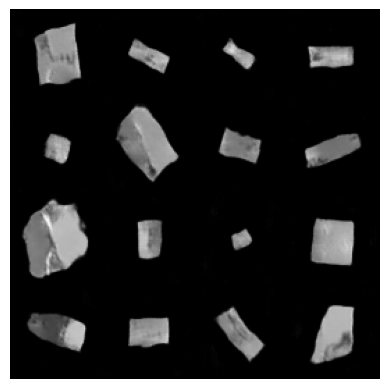

Output()

                         Epoch 51 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.41312835943965487 │ 2.1407174921264285 │ 72.43704509735107    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 52 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40211469534867866 │ 2.170307679679066 │ 72.59569549560547    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 53 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40219176805819185 │ 2.1722678222214453 │ 72.21887135505676    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 54 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4260691375778125 │ 2.094679638886223 │ 72.66329169273376    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 55 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39947712916535694 │ 2.169159782389863 │ 72.36185002326965    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 56 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39920155156534703 │ 2.1887825430391694 │ 73.14994430541992    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 57 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3951855446583928 │ 2.205569923304902 │ 72.59568166732788    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 58 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39676233354848794 │ 2.1911758371054555 │ 72.23398327827454    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 59 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40191951098914347 │ 2.1694254738073377 │ 72.37582468986511    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 60 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3947586325791697 │ 2.209904062671783 │ 72.12167096138       │
└────────────────────┴───────────────────┴──────────────────────┘

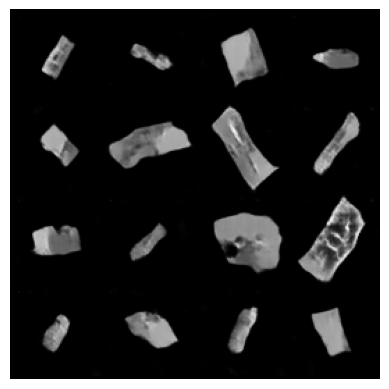

Output()

                        Epoch 61 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3941769271422499 │ 2.250893942654704 │ 72.42469143867493    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 62 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40852497084833944 │ 2.1938796563270375 │ 72.26039671897888    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 63 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40003033501271623 │ 2.1784372135473133 │ 72.00435185432434    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 64 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.40355815693212393 │ 2.19394509061076 │ 73.09151840209961    │
└─────────────────────┴──────────────────┴──────────────────────┘

Output()

                         Epoch 65 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3940343032248866 │ 2.2199232216460256 │ 72.74203038215637    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 66 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39054298029540063 │ 2.223592038162219 │ 72.3584885597229     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 67 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4057543108257623 │ 2.150923709423778 │ 72.3132095336914     │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 68 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3899080249638603 │ 2.259593269314629 │ 72.34612035751343    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 69 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4001411499497228 │ 2.2134901453702214 │ 72.97843813896179    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 70 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39396219369702445 │ 2.200653246035591 │ 72.43621468544006    │
└─────────────────────┴───────────────────┴──────────────────────┘

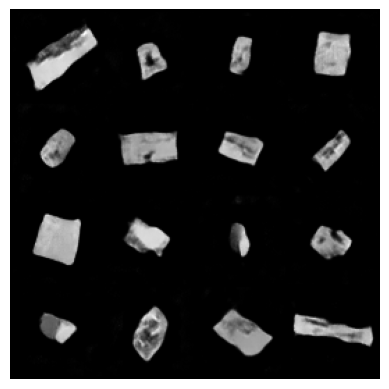

Output()

                         Epoch 71 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39120369321241166 │ 2.2457305865165904 │ 73.89591646194458    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 72 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.394710543627937  │ 2.2078023644301075 │ 73.64792466163635    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 73 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3949341035117737 │ 2.201812517909577 │ 72.99504160881042    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 74 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3903325341951352 │ 2.2187869143181334 │ 72.09219026565552    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 75 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4004807671228537 │ 2.1943356571867825 │ 72.0982735157013     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 76 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3937316579750171 │ 2.224283471084631 │ 72.22079277038574    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 77 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38583132862663877 │ 2.2536081279428624 │ 72.13675260543823    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 78 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3908951135869986 │ 2.227089864948687 │ 72.1633448600769     │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 79 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39636619688984687 │ 2.2116383776878017 │ 71.73943614959717    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 80 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38337156576470444 │ 2.2439644911799568 │ 71.34292364120483    │
└─────────────────────┴────────────────────┴──────────────────────┘

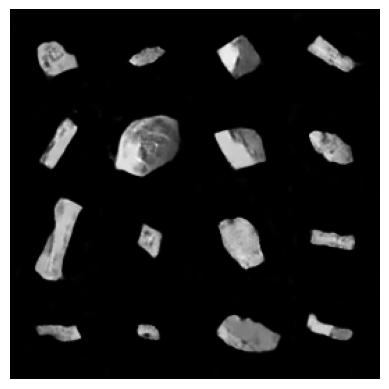

Output()

                         Epoch 81 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39851589286670136 │ 2.2151319398857154 │ 71.39786410331726    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 82 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.385536200131852  │ 2.2772657130472957 │ 71.3178129196167     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 83 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3781984710274413 │ 2.288115391906458 │ 71.42350244522095    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 84 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.41261735853676595 │ 2.1796373743980455 │ 71.3024115562439     │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 85 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38790604738762585 │ 2.2649045527552643 │ 71.36499810218811    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 86 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38955690637944984 │ 2.210240426916665 │ 71.30983138084412    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 87 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38737032826716145 │ 2.2422660033162027 │ 71.36689853668213    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 88 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3914411117474492 │ 2.2595587744118686 │ 71.29718923568726    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 89 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.4009709054479203 │ 2.2060434551665575 │ 71.51723861694336    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 90 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38733582669934524 │ 2.25099821707692 │ 71.39749336242676    │
└─────────────────────┴──────────────────┴──────────────────────┘

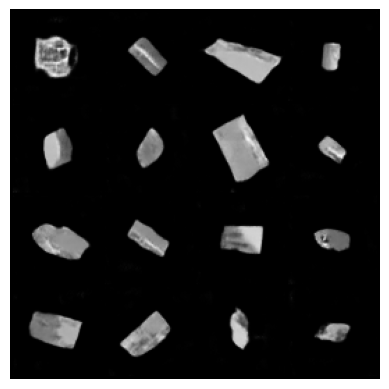

Output()

                         Epoch 91 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3861055375097659 │ 2.2145187643389352 │ 71.38888835906982    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 92 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3875932507812025 │ 2.253019496846123 │ 71.34304594993591    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 93 Summary                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38984822103390676 │ 2.2326644822812307 │ 71.36678957939148    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 94 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38598081050589444 │ 2.253280989849529 │ 71.3876953125        │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 95 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38631802187940945 │ 2.278873270883347 │ 71.36608529090881    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 96 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38703932196568375 │ 2.271195634866294 │ 71.33865904808044    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 97 Summary                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss  ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38209436162592125 │ 2.2734705253531 │ 71.43548488616943    │
└─────────────────────┴─────────────────┴──────────────────────┘

Output()

                         Epoch 98 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38771571728368154 │ 2.246272608494987 │ 71.39705634117126    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 99 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38003589741338173 │ 2.256678740056559 │ 71.34581398963928    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 100 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37787407408126245 │ 2.262456951240381 │ 71.40629982948303    │
└─────────────────────┴───────────────────┴──────────────────────┘

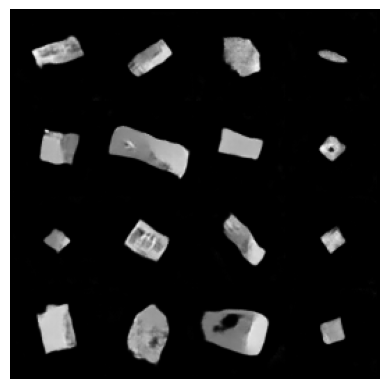

Output()

                        Epoch 101 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3863527972858173 │ 2.2380621258062297 │ 71.40310621261597    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 102 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38558593820840026 │ 2.265130757809447 │ 71.3755452632904     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 103 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38586032314422414 │ 2.2635984171312837 │ 71.42758584022522    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 104 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38404008165335124 │ 2.3122859791444896 │ 71.33438301086426    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 105 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3810892309814977 │ 2.2632592672738023 │ 71.40789127349854    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 106 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3847585211927518 │ 2.2839282600643536 │ 71.32723474502563    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 107 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3757350925629893 │ 2.2877069250844158 │ 71.35081839561462    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 108 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3818123457721247 │ 2.272115995708746 │ 71.33239722251892    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 109 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3822636750940317 │ 2.270236504725374 │ 71.41031527519226    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 110 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3820785208822439 │ 2.262632810840972 │ 71.41297459602356    │
└────────────────────┴───────────────────┴──────────────────────┘

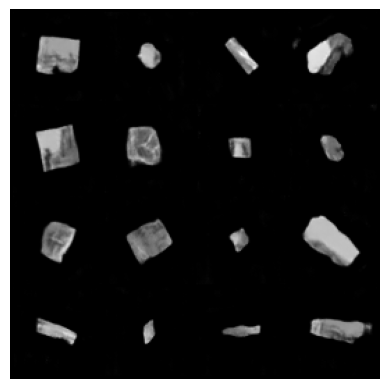

Output()

                        Epoch 111 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3797833656731505 │ 2.258959744684993 │ 71.43737697601318    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 112 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38566245895605117 │ 2.2786460475038033 │ 71.43660354614258    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 113 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3788491378957852 │ 2.2600257905146566 │ 71.42514061927795    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 114 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38814795055328466 │ 2.2869173874870277 │ 71.35585021972656    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                       Epoch 115 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3902600924618328 │ 2.21842029700264 │ 71.39840412139893    │
└────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 116 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3834437102365037 │ 2.2412598588215276 │ 71.36536073684692    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 117 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3859191996792254 │ 2.212065033257579 │ 71.36249160766602    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 118 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3819254176875654 │ 2.2781409447947247 │ 71.43982791900635    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 119 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3736991035862091 │ 2.3034573088819608 │ 71.35987734794617    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 120 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38232798069810714 │ 2.2944404947491117 │ 71.35270380973816    │
└─────────────────────┴────────────────────┴──────────────────────┘

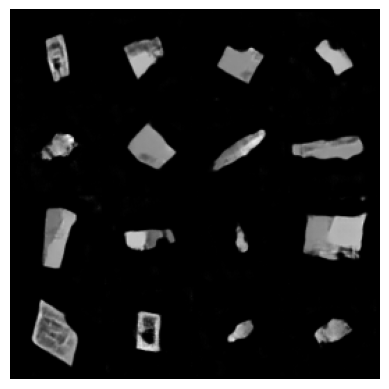

Output()

                        Epoch 121 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.378077054366517  │ 2.3037391097400897 │ 71.40855741500854    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 122 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3762718513369941 │ 2.279729971108726 │ 71.40184211730957    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 123 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3858005139774408 │ 2.246449933455775 │ 71.41315841674805    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 124 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37169427479417944 │ 2.3202491503554032 │ 71.47040796279907    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 125 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.39940829398913885 │ 2.233395802041593 │ 71.42276525497437    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 126 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37278336391281397 │ 2.2983990665822747 │ 71.38096475601196    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 127 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3752602655857135 │ 2.2969639537433464 │ 71.42252373695374    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 128 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3711342049863773 │ 2.321027973779855 │ 71.35345506668091    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                       Epoch 129 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3854267593389883 │ 2.26026700746518 │ 71.32232475280762    │
└────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 130 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3744479290212686 │ 2.3127047689958884 │ 71.43715620040894    │
└────────────────────┴────────────────────┴──────────────────────┘

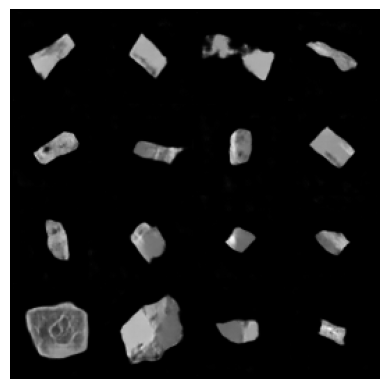

Output()

                        Epoch 131 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3874710944894785 │ 2.255243823455926 │ 71.38473963737488    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 132 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37363168873345126 │ 2.2989367995018397 │ 71.32839250564575    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 133 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36760791755331973 │ 2.3164921031592374 │ 71.3656005859375     │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 134 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3818690836810456 │ 2.2704619808128466 │ 71.37127327919006    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 135 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.378392349035976  │ 2.2713789646617903 │ 71.41428589820862    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 136 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3764747731601849 │ 2.266784780322553 │ 71.43259739875793    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 137 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3767800116881776 │ 2.2782228225336287 │ 71.41906714439392    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 138 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3774958317653059 │ 2.2876908388762427 │ 71.366544008255      │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 139 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37487866389103974 │ 2.295553149887548 │ 71.51877665519714    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 140 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37287323857648685 │ 2.2808542891432304 │ 71.39030766487122    │
└─────────────────────┴────────────────────┴──────────────────────┘

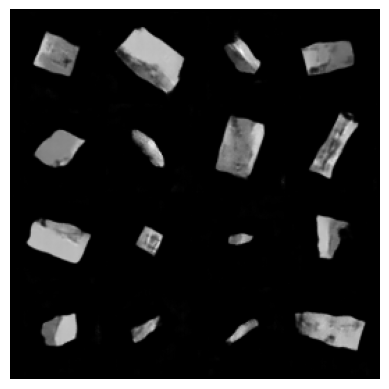

Output()

                        Epoch 141 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3725023382007124 │ 2.313480611426381 │ 71.34229159355164    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 142 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37479422324762557 │ 2.284342773806173 │ 71.33929491043091    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 143 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3719080542794432 │ 2.3277500256562766 │ 71.29731297492981    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 144 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3665696490115632 │ 2.314389023156212 │ 71.45265078544617    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 145 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38000317313038884 │ 2.2935925200343514 │ 71.35895085334778    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                       Epoch 146 Summary                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss  ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37473030583546185 │ 2.2960523965831 │ 71.39455008506775    │
└─────────────────────┴─────────────────┴──────────────────────┘

Output()

                        Epoch 147 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3774510370656705 │ 2.2618746761315927 │ 71.47853565216064    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                       Epoch 148 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3725776538110008 │ 2.28763599212939 │ 71.43618178367615    │
└────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 149 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3652233466172752 │ 2.322023391723633 │ 71.40677261352539    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 150 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3755049130406243 │ 2.2550616521423996 │ 71.33585906028748    │
└────────────────────┴────────────────────┴──────────────────────┘

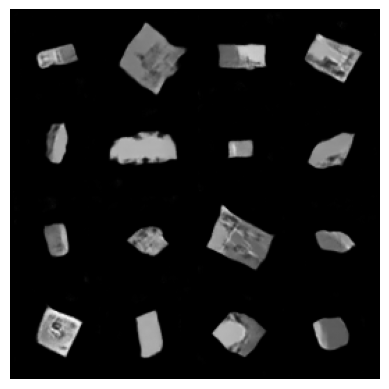

Output()

                         Epoch 151 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36956461102436905 │ 2.3228391827866672 │ 71.36602282524109    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 152 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3754319353415943 │ 2.2859409415302947 │ 71.3583312034607     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 153 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37174689550750173 │ 2.2942278950739974 │ 71.37320375442505    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 154 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37498414878266306 │ 2.2900289733188983 │ 71.35443663597107    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 155 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36620382683726543 │ 2.336422054150615 │ 71.37372612953186    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 156 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36674717440011023 │ 2.3117763615263915 │ 71.36958885192871    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 157 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36962960446223664 │ 2.2967347826439735 │ 71.33400797843933    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 158 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.38629403043859684 │ 2.229584521759813 │ 71.42798781394958    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 159 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37439677585808995 │ 2.267924528152417 │ 71.3136956691742     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 160 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37209865546074156 │ 2.3026429031984494 │ 71.46054697036743    │
└─────────────────────┴────────────────────┴──────────────────────┘

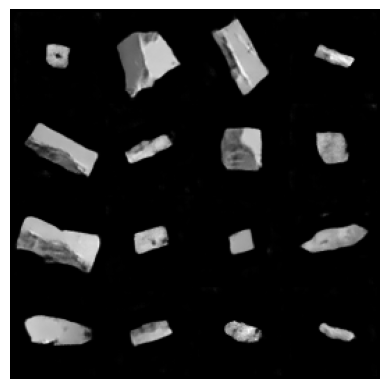

Output()

                        Epoch 161 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3673662733726989 │ 2.296615045291547 │ 71.36521220207214    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 162 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3735334566606881 │ 2.2730072232100147 │ 71.38852524757385    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 163 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3706606938816107 │ 2.3295455314099978 │ 71.34942650794983    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 164 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3670594944550207 │ 2.3165300585591373 │ 71.39801263809204    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 165 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3687254391348781 │ 2.311592729708638 │ 71.3807544708252     │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 166 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37398566929296184 │ 2.2758746328064428 │ 71.38631558418274    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 167 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3675409355483497 │ 2.2855967330856446 │ 71.3397536277771     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 168 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37004160481139114 │ 2.3430741063702984 │ 71.42113995552063    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 169 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3678403644325634 │ 2.299981646644422 │ 71.39308977127075    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 170 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36605833313716485 │ 2.335781417906094 │ 71.37213563919067    │
└─────────────────────┴───────────────────┴──────────────────────┘

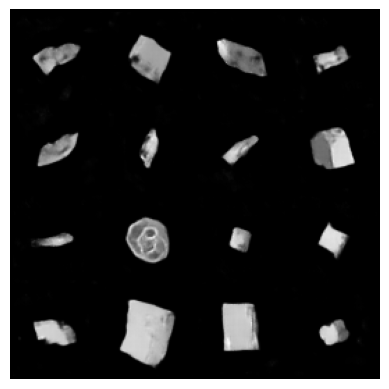

Output()

                        Epoch 171 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3912811645874962 │ 2.217875152826309 │ 71.33557105064392    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 172 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36659008892961203 │ 2.2621102338781753 │ 71.46225452423096    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 173 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36949820707019526 │ 2.2891023423725043 │ 71.2924427986145     │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 174 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3657658338165893 │ 2.320841839900032 │ 71.38912010192871    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                       Epoch 175 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3682820777923535 │ 2.29327316425098 │ 71.31114864349365    │
└────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 176 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3693948428090007 │ 2.316347261587271 │ 71.38327217102051    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 177 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3666897896950999 │ 2.3254918880736866 │ 71.33393478393555    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 178 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36536722604078226 │ 2.3131813005136608 │ 71.28450059890747    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 179 Summary                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36626354040810094 │ 2.31120141664633 │ 71.35983991622925    │
└─────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 180 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36721517140872945 │ 2.321560892434166 │ 71.29000425338745    │
└─────────────────────┴───────────────────┴──────────────────────┘

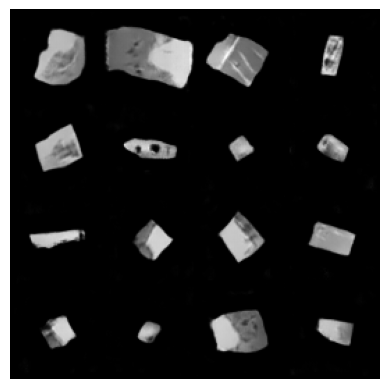

Output()

                        Epoch 181 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3703776411355113 │ 2.317681848621978 │ 71.4176275730133     │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 182 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3701576734312807 │ 2.2938885823987163 │ 71.46122336387634    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 183 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37631668612218133 │ 2.292375644555869 │ 71.46858501434326    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 184 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.370993618195811  │ 2.3127719493338854 │ 71.43461489677429    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 185 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36331055387140465 │ 2.3111687125489353 │ 71.43850517272949    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 186 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3645383628983848 │ 2.312454425679228 │ 71.46522164344788    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 187 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36262091756247866 │ 2.3304162707191685 │ 71.40054988861084    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 188 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.37082774637225335 │ 2.3060790174685346 │ 71.35033369064331    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 189 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3676075956311089 │ 2.318734700306536 │ 71.47349977493286    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 190 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3685401512411075 │ 2.303357432825497 │ 71.43350386619568    │
└────────────────────┴───────────────────┴──────────────────────┘

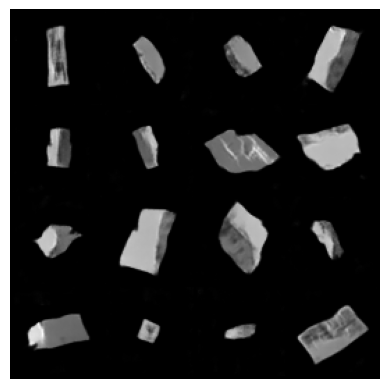

Output()

                       Epoch 191 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3670111589919264 │ 2.31659394788285 │ 71.35641098022461    │
└────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 192 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36313109866346416 │ 2.314616778407234 │ 71.4703311920166     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 193 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36860506841169   │ 2.3155891560137083 │ 71.36470675468445    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 194 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3623260464340734 │ 2.3225991623089337 │ 71.42603540420532    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 195 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36568303906117766 │ 2.3336642683504487 │ 71.32300281524658    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 196 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3782376961205333 │ 2.2854666953650526 │ 71.39576840400696    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 197 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3683988905181519 │ 2.2779003252236607 │ 71.37363028526306    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 198 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35908534304021644 │ 2.337328313448178 │ 71.43432521820068    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 199 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3640640333247261 │ 2.323008951097251 │ 71.39217400550842    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 200 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3646777799716011 │ 2.307853163621677 │ 71.32950782775879    │
└────────────────────┴───────────────────┴──────────────────────┘

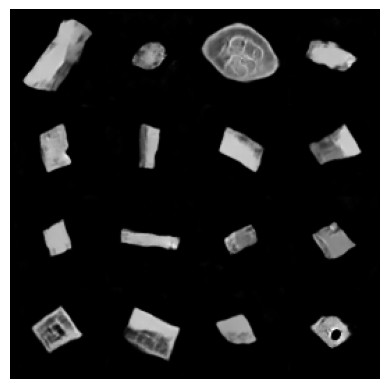

Output()

                        Epoch 201 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36722433167143753 │ 2.329626649522934 │ 71.31731152534485    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 202 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36669890587322246 │ 2.301439399345995 │ 71.39768886566162    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 203 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36899590044737623 │ 2.2995334707509976 │ 71.375009059906      │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 204 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3659974205227325 │ 2.3167497403324604 │ 71.31225800514221    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 205 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36054713381365083 │ 2.3078581825993694 │ 71.32980275154114    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 206 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3680981606149826 │ 2.3296852852589787 │ 71.31487202644348    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 207 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3652611560524462 │ 2.318713845917211 │ 71.36299657821655    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 208 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3610919830136406 │ 2.301282888403335 │ 71.39587545394897    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 209 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3639880089333263 │ 2.3286545076690164 │ 71.3216278553009     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 210 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3626187660823615 │ 2.338452239767812 │ 71.35427355766296    │
└────────────────────┴───────────────────┴──────────────────────┘

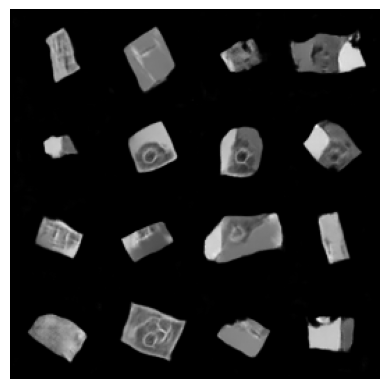

Output()

                        Epoch 211 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3628821723377362 │ 2.323307835255949 │ 71.45102643966675    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 212 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36303022894234704 │ 2.299271978890172 │ 71.42491817474365    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 213 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3620065001253122 │ 2.3382571570027753 │ 71.3267834186554     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 214 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36358958082838944 │ 2.3177602812885856 │ 71.34969019889832    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 215 Summary                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss   ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36231249589889575 │ 2.33121157911258 │ 71.3891224861145     │
└─────────────────────┴──────────────────┴──────────────────────┘

Output()

                        Epoch 216 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3632630432566134 │ 2.3286200055299093 │ 71.34416913986206    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 217 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.379820212579002  │ 2.278726522057963 │ 71.390695810318      │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 218 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36577119347386466 │ 2.2967940222341032 │ 71.37185740470886    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 219 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3607474337941922 │ 2.348378874242496 │ 71.37866520881653    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 220 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3589808477189975 │ 2.3096735820221825 │ 71.34354519844055    │
└────────────────────┴────────────────────┴──────────────────────┘

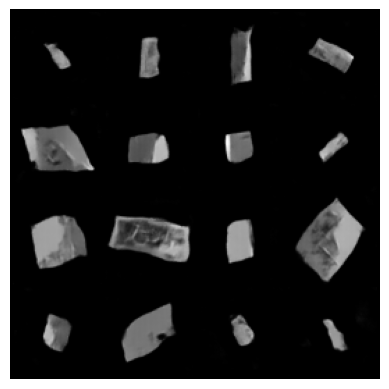

Output()

                         Epoch 221 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35816073398620557 │ 2.3156287388298837 │ 71.43955683708191    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 222 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35963321274842697 │ 2.345670692265605 │ 71.36824297904968    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 223 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36066982416680066 │ 2.319810578617425 │ 71.4688823223114     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 224 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36509169347750875 │ 2.3196649802759435 │ 71.44250059127808    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 225 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3665563580327141 │ 2.2837169575995913 │ 71.42998123168945    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 226 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36209436613149915 │ 2.321014952354919 │ 71.4469907283783     │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 227 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3603732770624252 │ 2.3081853338323843 │ 71.37498950958252    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 228 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3600153937316931 │ 2.3064897997310747 │ 71.42065334320068    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 229 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36190205203077663 │ 2.297451982863795 │ 71.48686695098877    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 230 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36064958048704715 │ 2.312013253998071 │ 71.49206972122192    │
└─────────────────────┴───────────────────┴──────────────────────┘

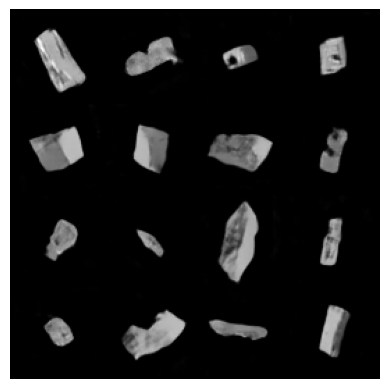

Output()

                         Epoch 231 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35811356852610654 │ 2.3486986263110614 │ 71.40239930152893    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 232 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3675194301734717 │ 2.295428601888041 │ 71.40752291679382    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 233 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3605638191151543 │ 2.3187898498373674 │ 71.42846751213074    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 234 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36016027986432037 │ 2.3302903514319717 │ 71.35659122467041    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 235 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3564071675268606 │ 2.3130604946575226 │ 71.45799112319946    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 236 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3650747582364006 │ 2.3517421468759117 │ 71.37438416481018    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 237 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3597307287085171 │ 2.331545355411383 │ 71.32362604141235    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 238 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35981215303317426 │ 2.331373836285771 │ 71.36008858680725    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 239 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3572992981432345 │ 2.327001305433889 │ 71.40120816230774    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 240 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3694187691226935 │ 2.2764002183755747 │ 71.46875071525574    │
└────────────────────┴────────────────────┴──────────────────────┘

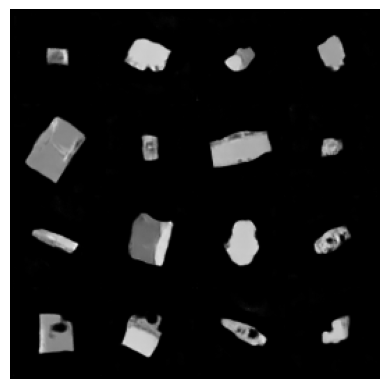

Output()

                        Epoch 241 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36039423047544095 │ 2.278192584507001 │ 71.49766850471497    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 242 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36713403796616456 │ 2.3097907262869155 │ 71.39189553260803    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 243 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3604499175906562 │ 2.298396001989468 │ 71.50259470939636    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 244 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35317595031695626 │ 2.314710609067362 │ 71.45662426948547    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 245 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35767781353606204 │ 2.325906349828068 │ 71.44834876060486    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 246 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3659570442792326 │ 2.2918923118243963 │ 71.4354727268219     │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 247 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35763183378944763 │ 2.3230878099465904 │ 71.40867185592651    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 248 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35645183130575064 │ 2.3337229642624293 │ 71.36791825294495    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 249 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36632057253164224 │ 2.3025402078232444 │ 71.37959909439087    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 250 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3555013033719108 │ 2.332320894677037 │ 71.42173600196838    │
└────────────────────┴───────────────────┴──────────────────────┘

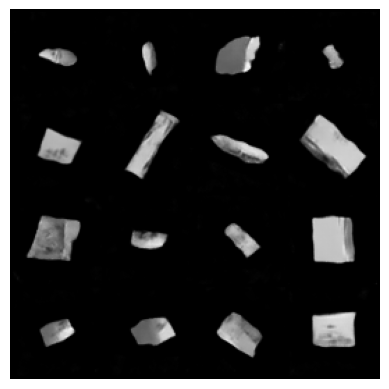

Output()

                        Epoch 251 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3563549236748546 │ 2.338167597881902 │ 71.45399737358093    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 252 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3580183977136216 │ 2.3165345778480506 │ 71.42202854156494    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 253 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.363514106399335  │ 2.3235941704469747 │ 71.48919916152954    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 254 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.356703372904287  │ 2.339298300088023 │ 71.39263367652893    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 255 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3638560204460217 │ 2.301567534097848 │ 71.42141079902649    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 256 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3601265734376999 │ 2.304854599622111 │ 71.28823399543762    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 257 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36036739610254576 │ 2.341425921779852 │ 71.32257747650146    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 258 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3600810153034929 │ 2.302055000497129 │ 71.45617604255676    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 259 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3547570801581057 │ 2.3326744919006055 │ 71.37977266311646    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 260 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3601546372278049 │ 2.329525124341154 │ 71.44080877304077    │
└────────────────────┴───────────────────┴──────────────────────┘

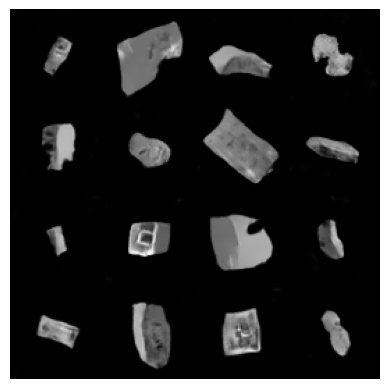

Output()

                        Epoch 261 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3867004341401231 │ 2.2335482086307894 │ 71.32004690170288    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 262 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3574487981133568 │ 2.325959740545803 │ 71.35576701164246    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 263 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.356446821754352  │ 2.322839245247765 │ 71.42698812484741    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 264 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3562040246142366 │ 2.2760455787372282 │ 71.37483096122742    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 265 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3534742384292066 │ 2.296625547134838 │ 71.43259501457214    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 266 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.356880979892164  │ 2.3333409047736144 │ 71.41762471199036    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 267 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35629003116497976 │ 2.3443390489005433 │ 71.39294767379761    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 268 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3752771018983457 │ 2.252751902079049 │ 71.44026231765747    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 269 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35435249515996575 │ 2.3284669672719205 │ 71.34652400016785    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 270 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35862854551583434 │ 2.2781576407603183 │ 71.40520644187927    │
└─────────────────────┴────────────────────┴──────────────────────┘

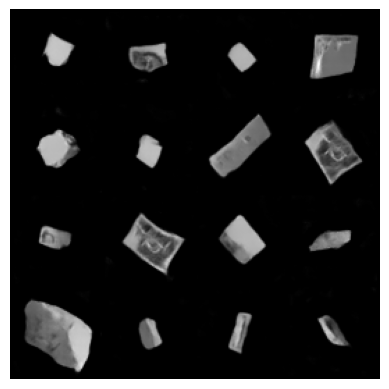

Output()

                         Epoch 271 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35592829819304495 │ 2.3038479737199533 │ 71.37554955482483    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 272 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35681705238720096 │ 2.3335852619177238 │ 71.36091780662537    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 273 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3626359510726441 │ 2.2971499030963303 │ 71.49996972084045    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 274 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3555271413189154 │ 2.317075879619525 │ 71.37435221672058    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 275 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36034967524175066 │ 2.2996161888582636 │ 71.47444891929626    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 276 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3546264689570418 │ 2.312636442458668 │ 71.37560200691223    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 277 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3528900483545785 │ 2.337306382557074 │ 71.43595743179321    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 278 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36206106008432165 │ 2.3054862561317297 │ 71.44784808158875    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 279 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35820940889108677 │ 2.355025815887573 │ 71.40515303611755    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 280 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35408082861489   │ 2.333044237603014 │ 71.38904762268066    │
└────────────────────┴───────────────────┴──────────────────────┘

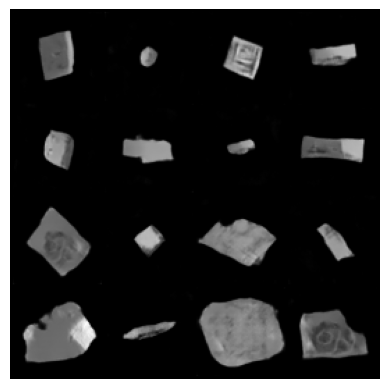

Output()

                        Epoch 281 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3610071702696645 │ 2.302970149836982 │ 71.41435074806213    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 282 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35603703077608784 │ 2.3184122997350967 │ 71.40077447891235    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 283 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35945135983415305 │ 2.3219545637837613 │ 71.42953515052795    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 284 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35363651740665253 │ 2.3515009388756067 │ 71.33636093139648    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 285 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35537664130472907 │ 2.322631001472473 │ 71.36807203292847    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 286 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3546074986838685 │ 2.3128748341871144 │ 71.38403701782227    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 287 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3574732338277677 │ 2.3311797269997885 │ 71.40170335769653    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 288 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35772776556091185 │ 2.3357815154063437 │ 71.41075730323792    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 289 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36343418104580033 │ 2.294548565968157 │ 71.41783404350281    │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 290 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3562812840405364 │ 2.2989450148500192 │ 71.44723701477051    │
└────────────────────┴────────────────────┴──────────────────────┘

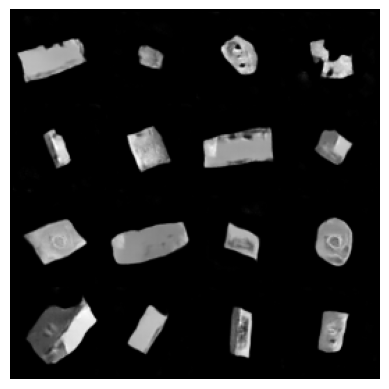

Output()

                        Epoch 291 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35663313006821534 │ 2.336638064811024 │ 71.439621925354      │
└─────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 292 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3556075571253658 │ 2.385861116095473 │ 71.39858293533325    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 293 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3548908531665802 │ 2.314366054230224 │ 71.35796689987183    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                        Epoch 294 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3583486204901442 │ 2.3283110933181956 │ 71.36439824104309    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 295 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3539496050855984 │ 2.3348327322889824 │ 71.45325183868408    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                         Epoch 296 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.36218183147259797 │ 2.3175830378319127 │ 71.38029408454895    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 297 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3549245891098778 │ 2.327928661538389 │ 71.40901374816895    │
└────────────────────┴───────────────────┴──────────────────────┘

Output()

                         Epoch 298 Summary                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss  ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.35402322024963917 │ 2.3235679986758733 │ 71.47360801696777    │
└─────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 299 Summary                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss     ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3579666347930226 │ 2.3389528906002592 │ 71.51332640647888    │
└────────────────────┴────────────────────┴──────────────────────┘

Output()

                        Epoch 300 Summary                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Discriminator Loss ┃ Generator Loss    ┃ Time Taken (seconds) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.3545982234965498 │ 2.311501863284614 │ 71.47364091873169    │
└────────────────────┴───────────────────┴──────────────────────┘

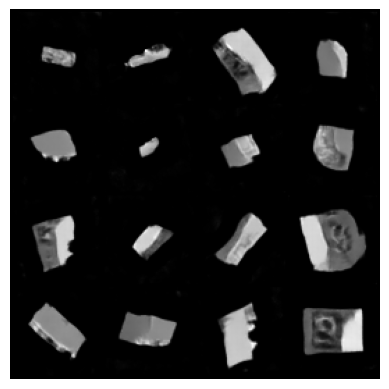

Training complete!


In [14]:
for i in range(epochs):
    train_loop(dataloader=train_data_loader, 
               discriminator=discriminator, 
               generator=generator, 
               discriminator_optimizer=discriminator_optimizer,
               generator_optimizer=generator_optimizer,
               discriminator_loss=discriminator_loss,
               generator_loss=generator_loss, 
               current_epoch=i + 1,
               total_epochs=epochs,
               device=device)
    
    if (i + 1) % 10 == 0:
        plot_and_save_generated_images_from_noise(n=16, generator=generator, current_epoch=i + 1)

print("Training complete!")